# <a id='toc1_'></a>[Scrape Emails of list of websites](#toc0_)
We plan to utilize the Maps API to scrape businesses based on targeted keywords. Subsequently, we will extract the websites of these businesses and scrape each website to extract email addresses. Finally, we will create a DataFrame to store the extracted emails.

**Table of contents**<a id='toc0_'></a>    
- [Scrape Emails of list of websites](#toc1_)    
  - [Use API to Extract business info](#toc1_1_)    
  - [Scrape Emails from websites](#toc1_2_)    
  - [Keep Top 5 used emails in front of @ sign](#toc1_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import requests
from bs4 import BeautifulSoup
import re
from tqdm import tqdm
import pandas as pd

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

## <a id='toc1_1_'></a>[Use API to Extract business info](#toc0_)
Use website: `https://console.apify.com/actors/nwua9Gu5YrADL7ZDj/runs/0UjqFFQoytyQz3sdQ#output` add keywords and location, we download the CSV afterwards from the browser.

In [3]:
market_data = pd.read_csv("./market_data/dataset_crawler-google-places_2024-04-01_21-12-46-155.csv")
market_data.shape

(207, 11)

In [4]:
market_data.columns

Index(['title', 'totalScore', 'reviewsCount', 'street', 'city', 'state',
       'countryCode', 'website', 'phone', 'categoryName', 'url'],
      dtype='object')

In [5]:
market_data.head(2)

,title,totalScore,reviewsCount,street,city,state,countryCode,website,phone,categoryName,url
0,Anfa uitzendbureau,3.7,3,Europalaan 2,Utrecht,NaN,NL,http://www.anfa-uitzendbureau.nl/,+31 6 23788216,Temp agency,https://www.google.com/maps/search/?api=1&quer...
1,Aditech Utrecht,2.3,3,Pretoriadreef 134,Utrecht,NaN,NL,https://www.aditech.nl/?utm_source=google&utm_...,+31 88 234 8333,Temp agency,https://www.google.com/maps/search/?api=1&quer...


In [6]:
new_df = market_data[['title', 'reviewsCount', 'street', 'city', 'website', 'phone', 'categoryName']]
new_df

,title,reviewsCount,street,city,website,phone,categoryName
0,Anfa uitzendbureau,3,Europalaan 2,Utrecht,http://www.anfa-uitzendbureau.nl/,+31 6 23788216,Temp agency
1,Aditech Utrecht,3,Pretoriadreef 134,Utrecht,https://www.aditech.nl/?utm_source=google&utm_...,+31 88 234 8333,Temp agency
2,Vetwork,15,Biltstraat 182,Utrecht,http://www.vetwork.nl/,+31 30 237 1130,Employment agency
3,AutiTalent B.V.,1,Vredenburg 40,Utrecht,https://www.autitalent.nl/,+31 85 081 9555,Temp agency
4,Markooij Uitzendbureau,22,Krommewetering 103 c,Utrecht,http://www.markooij.nl/,+31 30 204 4208,Temp agency
...,...,...,...,...,...,...,...
202,Carrière Vormer,0,Papendorpseweg 100,Utrecht,http://carrierevormer.nl/,+31 30 889 1897,Recruiter
203,FBRC GGZ Werving,14,Lange Viestraat 2b,Utrecht,http://www.ggz-werving.nl/,+31 88 742 5991,Recruiter
204,Morgan Lab,1,St Jacobsstraat 129,Utrecht,https://www.morganlab.nl/,+31 30 200 4805,Recruiter
205,Uitbestedingscentrum,0,Orteliuslaan 850,Utrecht,http://www.uitbestedingscentrum.nl/,+31 6 14208805,Technology park


## <a id='toc1_2_'></a>[Scrape Emails from websites](#toc0_)

In [7]:
def extract_emails(url):
    try:
        # Get the webpage content with a timeout of 30 seconds
        response = requests.get(url, timeout=30)
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Check if the website allows crawling
        if not check_robots_txt(url):
            return "This website does not allow crawling"
        
        # Find the navigation bar items with the name "Contact"
        contact_links = soup.find_all('a', text=re.compile(r'Contact', re.IGNORECASE))
        
        # Try finding contact link with capital "C"
        if not contact_links:
            contact_links = soup.find_all('a', text=re.compile(r'Contact'))
        
        if contact_links:
            # Navigate to the contact page
            contact_url = contact_links[0]['href']
            if not contact_url.startswith('http'):
                contact_url = url + contact_url  # Construct absolute URL if relative URL is provided
            contact_response = requests.get(contact_url, timeout=10)
            contact_soup = BeautifulSoup(contact_response.content, 'html.parser')
            
            # Extract email addresses from the contact page
            emails = find_emails(contact_soup)
            if emails:
                return emails
            else:
                return "Email not found on the contact page"
        else:
            #print(f"No 'Contact' link found on {url}. Trying /contact page.")
            contact_response = requests.get(url + '/contact', timeout=10)
            contact_soup = BeautifulSoup(contact_response.content, 'html.parser')
            
            # Extract email addresses from the /contact page
            emails = find_emails(contact_soup)
            if emails:
                return emails
            else:
                return "Email not found on the /contact page"
    except Exception as e:
        #print(f"Error scraping {url}: {e}")
        return []

def find_emails(soup):
    # Extract email addresses using a refined regex pattern
    email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b'
    email_matches = soup.find_all(string=re.compile(email_pattern))
    emails = []
    for match in email_matches:
        emails.extend(re.findall(email_pattern, match))
    return emails

def check_robots_txt(url):
    try:
        # Get the robots.txt content
        base_url = url.split('/')[0] + '//' + url.split('/')[2]
        robots_url = base_url + '/robots.txt'
        response = requests.get(robots_url)
        
        # Check if the website allows crawling
        if response.status_code == 200:
            return True
        else:
            return False
    except Exception as e:
        #print(f"Error checking robots.txt for {url}: {e}")
        return False

In [8]:
tqdm.pandas()  # Use tqdm with pandas apply

# Apply extract_emails function to each URL and track progress with tqdm
new_df['emails'] = new_df['website'].progress_apply(extract_emails)

  0%|          | 0/207 [00:00<?, ?it/s]C:\Users\gingg\AppData\Local\Temp\ipykernel_24480\3838420814.py:12: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  contact_links = soup.find_all('a', text=re.compile(r'Contact', re.IGNORECASE))
C:\Users\gingg\AppData\Local\Temp\ipykernel_24480\3838420814.py:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  contact_links = soup.find_all('a', text=re.compile(r'Contact'))
100%|██████████| 207/207 [11:58<00:00,  3.47s/it]
C:\Users\gingg\AppData\Local\Temp\ipykernel_24480\1874308394.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['emails'] = new_df['website'].progress_apply(extract_emails)


In [9]:
new_df.head(2)

,title,reviewsCount,street,city,website,phone,categoryName,emails
0,Anfa uitzendbureau,3,Europalaan 2,Utrecht,http://www.anfa-uitzendbureau.nl/,+31 6 23788216,Temp agency,"[info@anfa.nl, administratie@anfa-uitzendburea..."
1,Aditech Utrecht,3,Pretoriadreef 134,Utrecht,https://www.aditech.nl/?utm_source=google&utm_...,+31 88 234 8333,Temp agency,[info@aditech.nl]


In [10]:
# Function to remove duplicate emails within a list
def remove_duplicates(emails):
    return list(set(emails))

new_df['emails'] = new_df['emails'].progress_apply(remove_duplicates)

100%|██████████| 207/207 [00:00<00:00, 207907.31it/s]
C:\Users\gingg\AppData\Local\Temp\ipykernel_24480\334104751.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['emails'] = new_df['emails'].progress_apply(remove_duplicates)


## <a id='toc1_3_'></a>[Keep Top 5 used emails in front of @ sign](#toc0_)

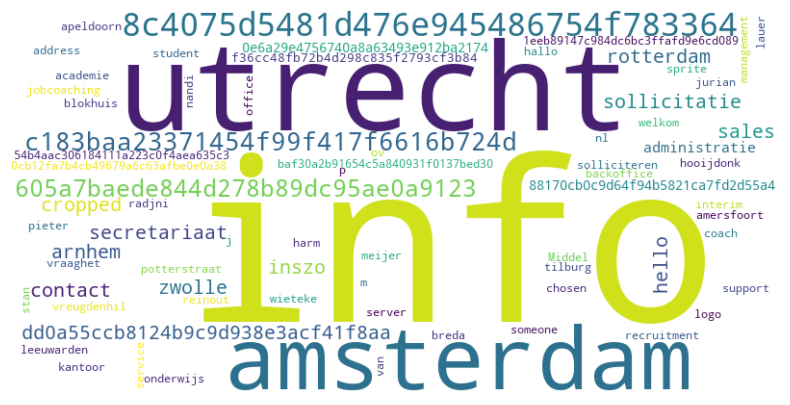

Top 5 words before '@' sign:
info: 83 occurrences
utrecht: 7 occurrences
amsterdam: 3 occurrences
8c4075d5481d476e945486754f783364: 2 occurrences
c183baa23371454f99f417f6616b724d: 2 occurrences


In [18]:
def create_word_cloud(emails):
    words = []
    for email in emails:
        # Split the email address at '@' sign and take the part before it
        email_parts = email.split('@')
        if len(email_parts) == 2:  # Ensure the email format is valid
            words.append(email_parts[0])
    # Convert the list of words into a single string
    text = ' '.join(words)
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

    # Count the frequency of each word
    word_freq = Counter(words)
    # Get the top 5 words
    top_5_words = word_freq.most_common(5)
    return top_5_words

# Apply the function to the 'Emails' column of the DataFrame
top_5_words = create_word_cloud(new_df['emails'].explode().dropna())
print("Top 5 words before '@' sign:")
for word, count in top_5_words:
    print(f"{word}: {count} occurrences")

In [26]:
def filter_info_emails(emails):
    if isinstance(emails, list):
        filtered_emails = [email for email in emails if email.startswith('info')]
        return filtered_emails if filtered_emails else None
    elif isinstance(emails, str):
        return [emails] if emails.startswith('info') else None
    else:
        return None

# Apply the function to the 'emails' column of the DataFrame
new_df['emails'] = new_df['emails'].progress_apply(filter_info_emails)

# Drop rows where the 'emails' column is empty
new_df.dropna(subset=['emails'], inplace=True)

100%|██████████| 207/207 [00:00<00:00, 207559.39it/s]


In [27]:
new_df.shape

(83, 8)

In [33]:
new_df.to_csv('./market_data/processed.csv', index=False)

## Check Distribution

In [34]:
oth = pd.read_csv("./market_data/processed.csv")
oth.shape

(83, 8)

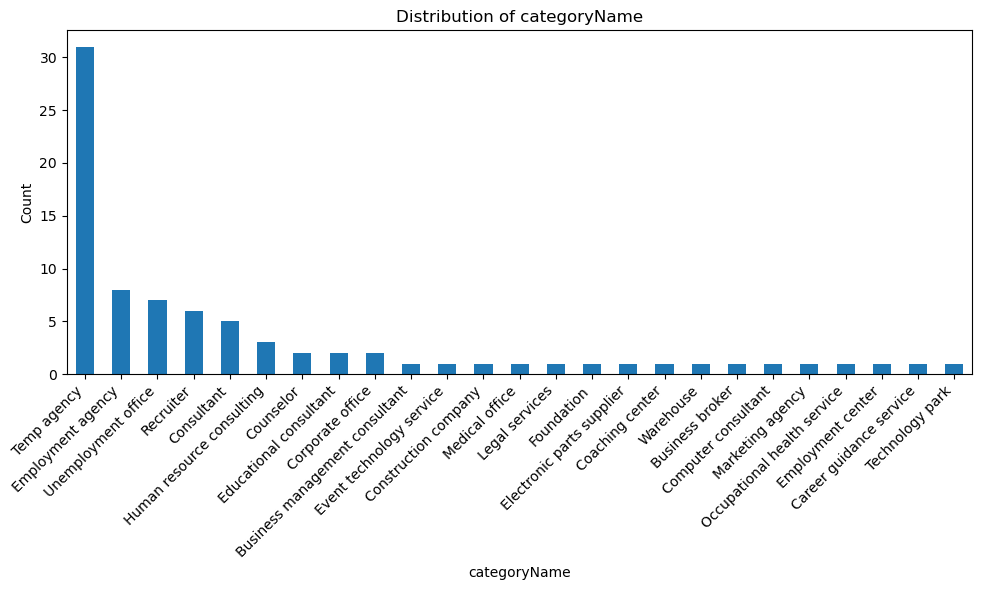

In [37]:
def plot_category_distribution(df, column_name):
    df[column_name].value_counts().plot(kind='bar', figsize=(10, 6), title=f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_category_distribution(oth, 'categoryName')